# Diagnosis
**Goal**: Our goal is to develop a model to predict the class of a binary output variable, *diagnosis*, based on 16 input features (*test1, …, test16*).  A secondary goal is to eliminate irrelevant input features and identify a small number of rules for diagnosis based on the remaining relevant features.

**Data**: The dataset contains labeled samples: 4000 for training and 1000 for testing. Each sample contains 16 input features, representing values for 16 tests. Its label, *diagnosis*, can take two possible values (0 and 1). In addition, there are 30 unlabeled samples. The training, test, and unlabeled samples are in CSV files "*diagnosis.train.csv*", "*diagnosis.test.csv*", and "*diagnosis.new.csv*", respectively.    

**Approach**: We shall choose a good model for this binary classification task based on results from *k*-fold cross-validation on the 4000 training samples. The selected model will be trained on all 4000 training samples and evaluated on the 1000 test samples. We shall then use the trained model to classify unlabeled samples. We shall also investigate whether a DecisionTreeClassifier with a few rules can achieve satisfactory classification accuracy.

## Import modules

In [1]:
import pandas as pd # for data handling
from sklearn.model_selection import cross_val_score # for cross-validation
from sklearn.metrics import accuracy_score, classification_report # evaluation metrics
import matplotlib.pyplot as plt # for plotting

# scikit-learn classifiers evaluated (change as desired)
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

## Get data
We shall extract the following 3 *CSV* files with data from the *zip* file "*diagnosis.data.zip*":
1. *diagnosis.train.csv*  with 4000 rows and 17 columns.   
2. *diagnosis.test.csv*   with  1000 rows and 17 columns.   
3. *diagnosis.new.csv*  with 30 rows and 17 columns.

The first column, **diagnosis**, in the files "*diagnosis.train.csv*" and "*diagnosis.test.csv*"  contains the binary output labels. The file "*diagnosis.new.csv*" contains unlabeled sampled; the first column **ID** is an identifier. The next 16 columns (*test_1*, ..., *test_16*) contain input features. 

We shall read data from these *CSV* files into *pandas* dataframes.

### Extract *CSV* files from *zip* file
We shall use unzip to extract CSV files from zip file with data.
- “**!**” allows us to run command line commands from a code cell in a notebook.


In [2]:
! unzip '/content/drive/MyDrive/Colab Notebooks/courses/sklearn_classifiers/data/diagnosis.data.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/courses/sklearn_classifiers/data/diagnosis.data.zip
replace diagnosis.new.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: diagnosis.new.csv       
  inflating: diagnosis.test.csv      
  inflating: diagnosis.train.csv     


### Read data into *pandas* dataframes
We shall use *pandas* **read_csv** function to read data from the CSV files "*diagnosis.train.csv*", "*diagnosis.test.csv*", and "*diagnosis.new.csv*" to *pandas* dataframes **train**, **test**, and **new**, respectively.

In [3]:
# Read data from CSV files into pandas dataframes
train = pd.read_csv('diagnosis.train.csv') # training data
test = pd.read_csv('diagnosis.test.csv') # test data
new = pd.read_csv('diagnosis.new.csv') # unlabeled data
# Show number of rows and columns in each dataframe
print('train contains %d rows and %d columns' %train.shape)
print('test contains %d rows and %d columns' %test.shape)
print('new contains %d rows and %d columns' %new.shape)
print('First 3 rows in train:') 
train.head(3) # display first 3 training samples 

train contains 4000 rows and 17 columns
test contains 1000 rows and 17 columns
new contains 30 rows and 17 columns
First 3 rows in train:


,diagnosis,test_1,test_2,test_3,test_4,test_5,test_6,test_7,test_8,test_9,test_10,test_11,test_12,test_13,test_14,test_15,test_16
0,1.0,0.111,0.312,0.639,0.170,0.256,0.099,0.381,0.758,0.847,0.325,0.726,0.635,0.613,0.722,0.893,0.830
1,1.0,0.705,0.551,0.492,0.786,0.376,0.881,0.832,0.049,0.290,0.740,0.488,0.937,0.092,0.885,0.122,0.627
2,1.0,0.662,0.766,0.485,0.076,0.771,0.010,0.509,0.947,0.075,0.575,0.824,0.772,0.145,0.915,0.740,0.843


In [4]:
print('Last 2 rows in new:') 
new.tail(2) # display last 2 unlabeled samples

Last 2 rows in new:


,ID,test_1,test_2,test_3,test_4,test_5,test_6,test_7,test_8,test_9,test_10,test_11,test_12,test_13,test_14,test_15,test_16
28,ID_029,0.858,0.738,0.664,0.605,0.269,0.507,0.048,0.471,0.979,0.506,0.718,0.079,0.534,0.583,0.606,0.048
29,ID_030,0.607,0.414,0.660,0.866,0.562,0.790,0.457,0.817,0.413,0.101,0.181,0.803,0.298,0.501,0.929,0.147


### Specify inputs and outputs
- **features**: List of the 16 input feature names
- **X_train**: $4000 \times 16$ array containing input values for training samples.
- **y_train**: Array containing labels for the 4000 training samples.
- **X_test**: $1000 \times 16$ array containing input values for test samples.
- **y_test**: Array containing labels for the 1000 training samples.
- **X_new**: $30 \times 16$ array containing input values for unlabeled samples.






In [5]:
features = list(train)[1:] # all but the first column header are feature names
print("features:", features)
X_train, X_test, X_new = train[features], test[features], new[features]
y_train, y_test = train.diagnosis, test.diagnosis
print('Shapes:')
print(f'X_train: {X_train.shape}, X_test: {X_test.shape}, X_new: {X_new.shape}')
print(f'y_train: {y_train.shape}, y_test: {y_test.shape}')

features: ['test_1', 'test_2', 'test_3', 'test_4', 'test_5', 'test_6', 'test_7', 'test_8', 'test_9', 'test_10', 'test_11', 'test_12', 'test_13', 'test_14', 'test_15', 'test_16']
Shapes:
X_train: (4000, 16), X_test: (1000, 16), X_new: (30, 16)
y_train: (4000,), y_test: (1000,)


## Evaluate models using *k*-fold cross-validation
We shall use **4**-fold cross-validation so that 3000 of the 4000 training samples are used for training and the remaining 1000 samples are used for validation in each fold. The mean cross-validation accuracy for each model with chosen hyper-parameters on the 4 runs will be computed using the command:
- **score = cross_val_score(model, X_train, y_train, cv=4).mean()**
> - *model*: classifier object with specified hyperparameters
> - *X_train*, *y_train*: Inputs and output labels for training
> - *cv*: number of folds in cross-validation
> - *mean*(): computes mean accuracy from the *cv* runs 

You can look up the documentation for each classifier, change hyper-parameter values, and observe the results. We shall also observe the time it takes to train and evaluate each model 4 times in this *4*-fold cross-validation process.


### GaussianNB

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

In [6]:
%%time
model = GaussianNB() # change hyperparameters as desired
score = cross_val_score(model, X_train, y_train, cv=4).mean() # mean cross-validation accuracy
print(f'Mean cross-validation accuracy = {score:0.4f}')

Mean cross-validation accuracy = 0.8207
CPU times: user 30.3 ms, sys: 1.54 ms, total: 31.9 ms
Wall time: 35.4 ms


### DecisionTreeClassifier

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [7]:
%%time
model = DecisionTreeClassifier(max_leaf_nodes=10) # change hyperparameters as desired
score = cross_val_score(model, X_train, y_train, cv=4).mean() # mean cross-validation accuracy
print(f'Mean cross-validation accuracy = {score:0.4f}')

Mean cross-validation accuracy = 0.9600
CPU times: user 123 ms, sys: 2.76 ms, total: 126 ms
Wall time: 133 ms


### RandomForestClassifier

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [8]:
%%time
model = RandomForestClassifier(n_estimators=10) # change hyperparameters as desired
score = cross_val_score(model, X_train, y_train, cv=4).mean() # mean cross-validation accuracy
print(f'Mean cross-validation accuracy = {score:0.4f}')

Mean cross-validation accuracy = 0.9577
CPU times: user 495 ms, sys: 5.02 ms, total: 500 ms
Wall time: 516 ms


### ExtraTreesClassifier

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html

In [9]:
%%time
model = ExtraTreesClassifier(n_estimators=100) # change hyperparameters as desired
score = cross_val_score(model, X_train, y_train, cv=4).mean() # mean cross-validation accuracy
print(f'Mean cross-validation accuracy = {score:0.4f}')

Mean cross-validation accuracy = 0.9193
CPU times: user 1.81 s, sys: 25.9 ms, total: 1.84 s
Wall time: 1.87 s


### KNeighborsClassifier

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [10]:
%%time
model = KNeighborsClassifier(n_neighbors=11, algorithm='brute') # change hyperparameters as desired
score = cross_val_score(model, X_train, y_train, cv=4).mean() # mean cross-validation accuracy
print(f'Mean cross-validation accuracy = {score:0.4f}')

Mean cross-validation accuracy = 0.7502
CPU times: user 576 ms, sys: 417 ms, total: 993 ms
Wall time: 533 ms


### LogisticRegression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [11]:
%%time
model = LogisticRegression(max_iter=10000) # change hyperparameters as desired
score = cross_val_score(model, X_train, y_train, cv=4).mean() # mean cross-validation accuracy
print(f'Mean cross-validation accuracy = {score:0.4f}')

Mean cross-validation accuracy = 0.7487
CPU times: user 115 ms, sys: 76.8 ms, total: 192 ms
Wall time: 103 ms


### SVC

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [12]:
%%time
model = SVC() # change hyperparameters as desired
score = cross_val_score(model, X_train, y_train, cv=4).mean() # mean cross-validation accuracy
print(f'Mean cross-validation accuracy = {score:0.4f}')

Mean cross-validation accuracy = 0.8405
CPU times: user 1.73 s, sys: 93.5 ms, total: 1.82 s
Wall time: 1.75 s


### MLPClassifier
https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [13]:
%%time
model = MLPClassifier(hidden_layer_sizes=100, max_iter=1000) # change hyperparameters as desired
score = cross_val_score(model, X_train, y_train, cv=4).mean() # mean cross-validation accuracy
print(f'Mean cross-validation accuracy = {score:0.4f}')

Mean cross-validation accuracy = 0.8742
CPU times: user 1min, sys: 45.9 s, total: 1min 46s
Wall time: 54.8 s


## Select a good model
Since a DecisionTree classifier has high cross-validation accuracy, we shall search for good hyper-parameter values for a DecisionTree model using cross-validation. In this example I shall vary the number of rules (*max_leaf_nodes*).

In [14]:
for k in range(2,15): # number of rules
    model = DecisionTreeClassifier(max_leaf_nodes=k)
    score = cross_val_score(model, X_train, y_train, cv=4).mean() # mean cross-validation accuracy
    print(f'Mean cross-validation accuracy with {k} rules = {score:0.4f}')

Mean cross-validation accuracy with 2 rules = 0.6372
Mean cross-validation accuracy with 3 rules = 0.7837
Mean cross-validation accuracy with 4 rules = 0.8810
Mean cross-validation accuracy with 5 rules = 0.9612
Mean cross-validation accuracy with 6 rules = 0.9610
Mean cross-validation accuracy with 7 rules = 0.9607
Mean cross-validation accuracy with 8 rules = 0.9602
Mean cross-validation accuracy with 9 rules = 0.9602
Mean cross-validation accuracy with 10 rules = 0.9602
Mean cross-validation accuracy with 11 rules = 0.9600
Mean cross-validation accuracy with 12 rules = 0.9595
Mean cross-validation accuracy with 13 rules = 0.9587
Mean cross-validation accuracy with 14 rules = 0.9590


For this classification problem, cross-validation accuracy increases as the number of rules increase up to 5, and then it starts decreasing. So we shall choose the following model:
- DecisionTreeClassifier(max_leaf_nodes=5)  

In [15]:
chosen_model = DecisionTreeClassifier(max_leaf_nodes=5) # chosen model
print(chosen_model) # display model parameters

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=5,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


## Train and test selected model

In [16]:
%%time
chosen_model.fit(X_train, y_train) # train selected model on ALL training examples
predicted = chosen_model.predict(X_test) # predicted diagnosis for test examples
acc = accuracy_score(y_test, predicted) # accuracy on test samples
print(f'Accuracy on test samples = {acc:0.4f}') # show test accuracy
print("Classification report on test samples:") # for precision, recall, F1-score
print(classification_report(y_test, predicted, digits=4)) # rounded to 4 decimal places

Accuracy on test samples = 0.9590
Classification report on test samples:
              precision    recall  f1-score   support

         0.0     0.9542    0.9782    0.9661       597
         1.0     0.9665    0.9305    0.9482       403

    accuracy                         0.9590      1000
   macro avg     0.9604    0.9544    0.9571      1000
weighted avg     0.9592    0.9590    0.9589      1000

CPU times: user 41.5 ms, sys: 0 ns, total: 41.5 ms
Wall time: 46 ms


## Predict class for unlabeled samples
We shall use our trained model to predict the output class for the unlabeled samples.

In [17]:
predicted_new = chosen_model.predict(X_new) # predicted classes for unlabeled samples
new_prediction = pd.DataFrame() # dataframe with predicted classes
new_prediction['ID'] = new.ID # identifiers for unlabeled samples
new_prediction['diagnosis'] = predicted_new # # predicted classes for unlabeled samples
new_prediction.to_csv('diagnosis.prediction.csv', index=False) # save as CSV file
new_prediction # display results

,ID,diagnosis
0,ID_001,0.0
1,ID_002,0.0
2,ID_003,0.0
3,ID_004,0.0
4,ID_005,0.0
5,ID_006,0.0
6,ID_007,0.0
7,ID_008,0.0
8,ID_009,0.0
9,ID_010,0.0


## Extract rules from Decision Tree
We shall visualize the decision tree using the *plot_tree* function
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html 

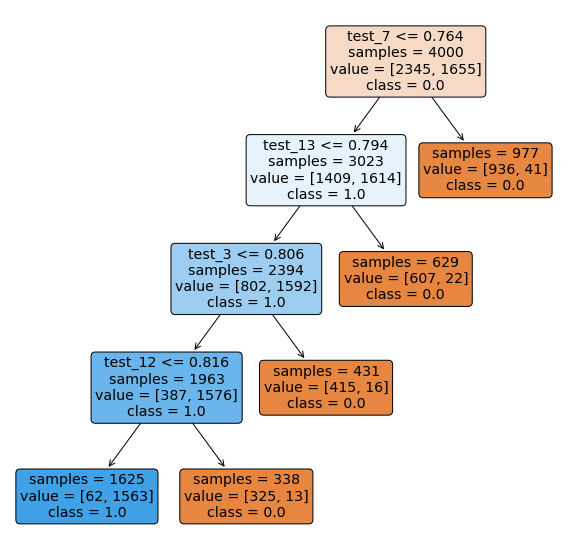

In [18]:
plt.figure(figsize=(10, 10)) # size of figure to be displayed

plot_tree(chosen_model, 
          feature_names=features, 
          class_names=[f'{c}' for c in chosen_model.classes_], 
          filled=True, rounded=True, impurity=False) # plot tree

plt.savefig("decision_tree.png") # save as PNG file
plt.show() # show tree

The Decision Tree encodes the following rules:

1. IF *test_7* $>$ 0.764 THEN *diagnosis* = 0.
2. IF *test_7* $\le$ 0.764 AND *test_13* $>$ 0.794 THEN *diagnosis* = 0.
3. IF *test_7* $\le$ 0.764 AND *test_13* $\le$ 0.794 AND *test_3* $>$ 0.806  THEN *diagnosis* = 0.
4. IF *test_7* $\le$ 0.764 AND *test_13* $\le$ 0.794 AND *test_3* $\le$ 0.806 AND *test_12* $>$ 0.816  THEN *diagnosis* = 0.
5. IF *test_7* $\le$ 0.764 AND *test_13* $\le$ 0.794 AND *test_3* $\le$ 0.806 AND *test_12* $\le$ 0.816  THEN *diagnosis* = 0.   

### Relevant features
The rules above use only 4 of the 16 tests as input features. The attribute *feature_importances_* of a trained decision tree may be used to infer the relative imprtance of features. We shall plot feature importances and confirm that only 4 of the tests (**test_3, test_7, test_12, test_13**) are relevant for this classification problem; the other 12 tests may eliminated without affecting classification accuracy. 

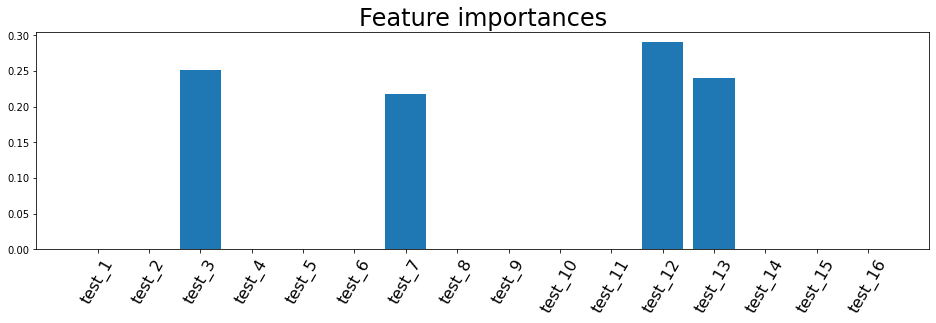

In [19]:
plt.figure(figsize=(16, 4)) # size of figure to be displayed
plt.bar(features, chosen_model.feature_importances_)
plt.xticks(rotation = 60, fontsize=16)
plt.title('Feature importances', fontsize=24)
plt.show()